In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gudhi as gd
import json

from glob import glob
import os
import tifffile as tf
import wasserstein as ws

from scipy import ndimage
from sklearn import manifold, cluster, decomposition, preprocessing

In [2]:
def get_diagrams(jsonfiles):
    diagh0 = [ np.empty((0,2)) for i in range(len(jsonfiles)) ]
    diagh1 = [ np.empty((0,2)) for i in range(len(jsonfiles)) ]

    for i in range(len(jsonfiles)):
        with open(jsonfiles[i]) as f:
            diag = [tuple(x) for x in json.load(f)]
        h1mask = np.sum([ diag[j][0] == 1 for j in range(len(diag)) ])
        diagh0[i] = np.asarray( [ x[1] for x in diag[h1mask:] ] )
        if h1mask > 0:
            diagh1[i] = np.asarray( [ x[1] for x in diag[:h1mask] ] )

    return diagh0, diagh1

def bottleneck_matrix(diagh0, diagh1, dfunction=gd.bottleneck_distance, **kwargs):
    bottleneck_h0 = np.zeros( (len(diagh0), len(diagh0)) )
    bottleneck_h1 = np.zeros( (len(diagh0), len(diagh0)) )
    
    for i in range(len(bottleneck_h0) - 1):
        for j in range(i+1, len(bottleneck_h0)):
    
            ## H0 ##
            d = dfunction(diagh0[i], diagh0[j], **kwargs)
            bottleneck_h0[i,j] = d
            bottleneck_h0[j,i] = d
    
            ## H1 ##
            d = dfunction(diagh1[i], diagh1[j], **kwargs)
            bottleneck_h1[i,j] = d
            bottleneck_h1[j,i] = d

    return bottleneck_h0, bottleneck_h1

def save_dmatrix(mtrx, filename):
    N = len(mtrx)
    dflat = mtrx[np.triu_indices(N, k=1)]
    pd.Series(dflat).to_csv(filename, index=False, header=None)
    return dflat

In [3]:
gsrc = '../gd_trans/'
sample = 'D2'
tsrc = gsrc + sample + '/'
ws_order = 1
dst = tsrc

transcriptomes = sorted([foo.split('/')[-2] for foo in glob(tsrc + '*/')])
print(len(transcriptomes), 'transcriptomes')
level = 'sub'

97 transcriptomes


In [4]:
tidx = 62
print('Checking', transcriptomes[tidx])
jsonfiles = sorted(glob(tsrc + transcriptomes[tidx] + '/*' + level + 'level.json'))
diag0, diag1 = get_diagrams(jsonfiles)

if len(jsonfiles) == 0:
    print('\n****\nNo JSONs detected for',transcriptomes[tidx], '\t[{}]\n****\n'.format(tidx))
else:
    print('Found',len(jsonfiles),'cells')

Checking GLYMA_12G027400
Found 2327 cells


In [5]:
# 1-Wasserstein

h0, h1 = bottleneck_matrix(diag0, diag1, ws.wasserstein_distance, order=ws_order, keep_essential_parts=False)
dmatrix = h0 + h1
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_wasserstein{}.csv'.format(ws_order)
_ = save_dmatrix(dmatrix, filename)

/home/eah4d/.local/lib/python3.10/site-packages/ot/lp/__init__.py:508: RuntimeWarning: invalid value encountered in divide
  b = b * a.sum(0) / b.sum(0,keepdims=True)
/home/eah4d/.local/lib/python3.10/site-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


In [6]:
# Bottleneck

h0, h1 = bottleneck_matrix(diag0, diag1, gd.bottleneck_distance)
dmatrix = np.maximum(h0, h1)
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_bottleneck.csv'
_ = save_dmatrix(dmatrix, filename)

In [11]:
N = len(jsonfiles)
A = np.zeros((N,N))
A[np.triu_indices(N,k=1)] = dflat
A += A.T
A

array([[  0. , 148. , 143. ,  60. , 200.5],
       [148. ,   0. , 148.5, 138. , 109.5],
       [143. , 148.5,   0. ,  84. , 183. ],
       [ 60. , 138. ,  84. ,   0. , 190.5],
       [200.5, 109.5, 183. , 190.5,   0. ]])

In [47]:
bdh0, bdh1 = bottleneck_matrix(diag0, diag1, gd.bottleneck_distance)
bd_mtrx = np.maximum(bdh0, bdh1)
dflat = bd_mtrx[np.triu_indices(len(jsonfiles), k=1)]
filename = tsrc + transcriptomes[tidx] + '_-_' + level + 'level_bottleneck.csv'
pd.Series(dflat).to_csv(filename, index=False, header=None)

array([28.5, 30. , 14. , 32. , 34.5, 28.5, 32. , 21. , 34.5, 32. ])

In [61]:
pd.read_csv(filename, header=None)

,0
0,28.5
1,30.0
2,14.0
3,32.0
4,34.5
5,28.5
6,32.0
7,21.0
8,34.5
9,32.0


In [8]:
mds_params = {'n_components':2, 'metric':True, 'random_state':42, 'dissimilarity':'precomputed', 'normalized_stress':False}
mds = dict()

for key in levels:
    mds[key] = manifold.MDS(**mds_params).fit_transform(bottle[key])

In [9]:
dbscan_params = {'eps':10, 'min_samples':3}
clust = dict()

for key in levels:
    clust[key] = cluster.DBSCAN(**dbscan_params).fit(mds[key][:,:2])

In [27]:
data = dict()
for key in levels:
    data[key] = pd.DataFrame(mds[key], columns=['MDS1', 'MDS2'])
    labs = clust[key].labels_
    scaler = preprocessing.StandardScaler().fit(mds[key][labs > -1])
    train = scaler.transform(mds[key])
    #PCA = decomposition.KernelPCA(n_components=1, random_state=42, kernel='rbf', gamma=0.01).fit(train[labs > -1])
    PCA = decomposition.PCA(n_components=1, random_state=42, whiten=False).fit(train[labs > -1])
    colors = PCA.transform(train).squeeze()
    data[key]['DBSCAN'] = labs
    data[key]['PCA1'] = colors

    indices = np.asarray([ os.path.splitext(subjsons[i])[0].split('_-_')[-2:] for i in range(len(subjsons)) ]).astype(int)
    data[key] = data[key].join(pd.DataFrame(indices, columns=['InternalID','ExternalID']))
    data[key] = data[key].join(df.loc[indices[:,0], ['X.location', 'Y.location']].reset_index(drop=True))
    data[key] = data[key].iloc[:, [4,5,6,7,0,1,3,2]]

meta = dict()
for key in levels:
    labs = clust[key].labels_
    ulabs, cts = np.unique(labs, return_counts=True)
    if -1 in ulabs:
        ulabs = np.hstack(([-1], ulabs[1:][np.argsort(cts[1:])[::-1]]))
    else:
        ulabs = ulabs[np.argsort(cts)[::-1]]
    meta[key] = {'vmin': np.min(data[key][data[key]['DBSCAN'] > -1 ]['PCA1']),
                 'vmax': np.max(data[key][data[key]['DBSCAN'] > -1 ]['PCA1']),
                 'labels': ulabs
                }

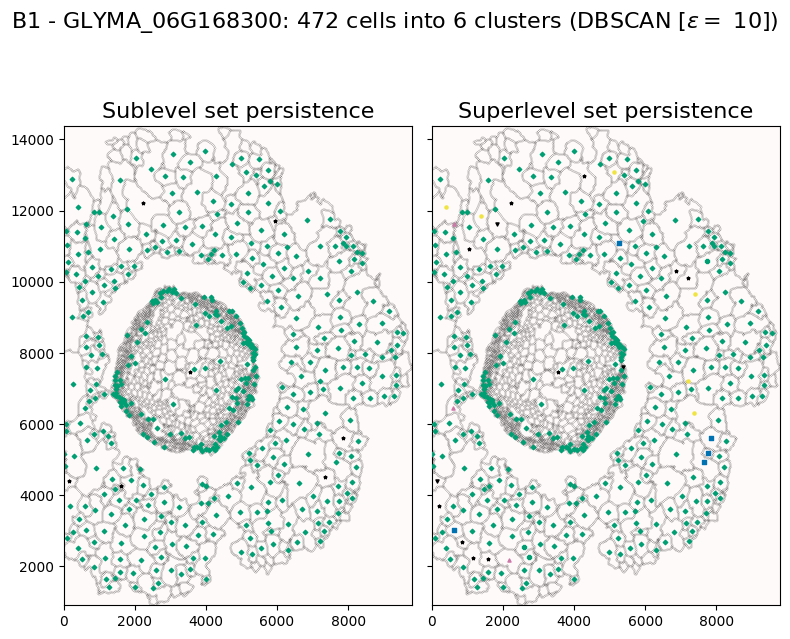

In [115]:
fig, ax = plt.subplots(1,2, figsize=(8,7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,key in enumerate(levels):
    ax[i].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.01, zorder=1, alpha=0.1)
    cellloc = cloc[key]
    
    for j in range(len(cellloc)):
        ax[i].scatter(cellloc[j][:,0], cellloc[j][:,1], s=5,
                      c=color[j%len(color)], marker=marker[j%len(marker)], zorder = len(cellloc) - j)
    
    ax[i].set_title(key.title() + ' set persistence', fontsize=fs)
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].set_facecolor('snow')

title = sample + ' - ' + transcriptomes[tidx] + ': {} cells into {} clusters (DBSCAN [$\\varepsilon = $ {}])'.format(len(subjsons), len(ulabs)-1, dbscan_params['eps'])
fig.suptitle(title, fontsize=fs)
fig.tight_layout();

In [118]:
cellloc

[array([[ 3546,  7472],
        [ 1611,  4244],
        [  143,  4395],
        [ 7351,  4505],
        [ 7845,  5593],
        [ 5932, 11692],
        [ 2223, 12203]]),
 array([[ 7209,  7213],
        [ 2524,  1392],
        [ 1279,  1412],
        [ 2010,  1427],
        [ 2651,  1532],
        [ 1192,  1642],
        [ 3013,  1889],
        [ 3313,  1780],
        [ 3996,  1643],
        [  867,  1973],
        [ 1952,  1802],
        [ 1453,  1676],
        [ 1590,  1839],
        [ 2598,  1887],
        [ 3545,  1923],
        [ 3961,  2246],
        [ 1173,  2237],
        [ 2178,  2189],
        [ 4994,  2407],
        [ 1583,  2196],
        [  519,  2214],
        [ 3639,  2246],
        [ 2725,  2271],
        [ 5300,  2358],
        [  411,  2524],
        [ 3046,  2624],
        [ 3450,  2556],
        [ 6301,  2463],
        [ 5874,  2619],
        [ 5562,  2514],
        [ 2583,  2550],
        [ 1618,  2649],
        [ 6797,  2952],
        [ 6555,  2679],
        [ 2259

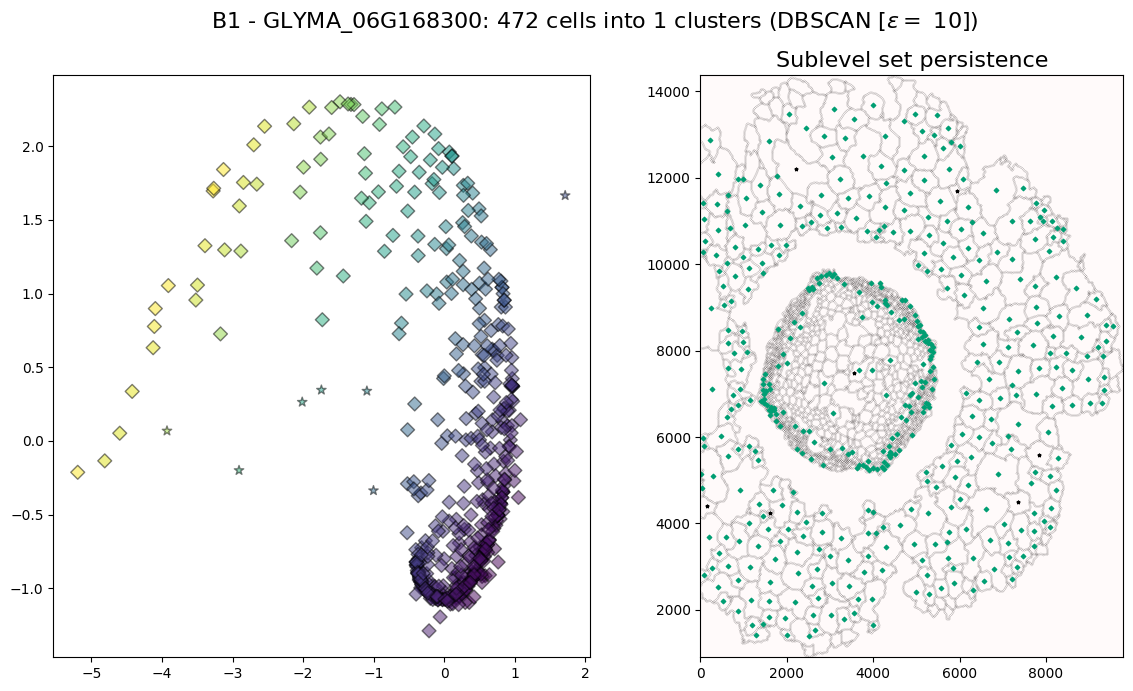

In [117]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
ax = np.atleast_1d(ax).ravel()
key = 'sublevel'
labs = clust[key].labels_
ulabs, cts = np.unique(labs, return_counts=True)
if -1 in ulabs:
    ulabs = np.hstack(([-1], ulabs[1:][np.argsort(cts[1:])[::-1]]))
else:
    ulabs = ulabs[np.argsort(cts)[::-1]]
scaler = preprocessing.StandardScaler().fit(mds[key][labs > -1])
train = scaler.transform(mds[key])
KPCA = decomposition.PCA(n_components=1, random_state=42, whiten=False).fit(train[labs > -1])
kpca = KPCA.transform(train).squeeze()
vmax = np.max(kpca)
vmin = np.min(kpca)

i = 0
for j in range(len(ulabs)):
    mask = labs == ulabs[j]
    ax[i].scatter(train[mask,0], train[mask,1], s=50, alpha=0.5, vmax=vmax, vmin=vmin,
                  c=kpca[mask], marker=marker[j%len(marker)], edgecolor='k')

i = 1
ax[i].scatter(wcoords[1], wcoords[0], c='gray', marker='.', s=0.01, zorder=1, alpha=0.1)
cellloc = cloc[key]
for j in range(len(cellloc)):
    ax[i].scatter(cellloc[j][:,0], cellloc[j][:,1], s=5,
                  c=, marker=marker[j%len(marker)], zorder = len(cellloc) - j)
    
    ax[i].set_title(key.title() + ' set persistence', fontsize=fs)
    ax[i].set_aspect('equal')
    ax[i].margins(0)
    ax[i].set_facecolor('snow')

title = sample + ' - ' + transcriptomes[tidx] + ': {} cells into {} clusters (DBSCAN [$\\varepsilon = $ {}])'.format(len(subjsons), len(ulabs)-1, dbscan_params['eps'])
fig.suptitle(title, fontsize=fs)
fig.tight_layout();

In [13]:
#from bokeh.plotting import ColumnDataSource, figure, output_file, show
#from bokeh.io import output_notebook, show
#from bokeh.models import TapTool, HoverTool

from bokeh import plotting as bkplt
from bokeh import io as bkio
from bokeh import models as bkmodels

bkio.output_notebook()

Loading BokehJS ...

In [14]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" alt="@imgs" width="200"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

In [15]:
wallsource = bkplt.ColumnDataSource(data={'x':wcoords[1], 'y':wcoords[0]})

In [16]:
# /home/eah4d/documents/mcarto/proc/B1/CYP93A1/diagnostic_CYP93A1_-_00000_-_00001.jpg
imgsrc = '../proc/' + sample + '/' + transcriptomes[tidx] + '/diagnostic_' + transcriptomes[tidx] + '_-_'

cds = [None for j in range(len(cloc[key])) ]

for j in range(len(cds)):
    foo = [ imgsrc + '{}_-_{}.jpg'.format(*cid[key][j][i]) for i in range(len(cid[key][j])) ]
    cds[j] = bkplt.ColumnDataSource(data={'x':cloc[key][j][:,0], 'y':cloc[key][j][:,1], 'imgs':foo})

In [17]:
cds[0].data

{'x': array([2638, 3627, 2785, 4422, 4570, 4614, 2246, 2300]),
 'y': array([5879, 5860, 6108, 6625, 6747, 6990, 8174, 8550]),
 'imgs': ['../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_302_-_317.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_348_-_363.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_427_-_441.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_601_-_616.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_608_-_623.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_708_-_724.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_1028_-_1045.jpg',
  '../proc/B1/GLYMA_06G065000/diagnostic_GLYMA_06G065000_-_1084_-_1101.jpg']}

In [18]:
#marker = ['*', 'D', 'o', 's', '^', 'v', 'P']
bkmarker = ['star', 'diamond', 'circle', 'square', 'triangle', 'inverted_triangle', 'plus']

In [31]:
j = 0

bkplt.output_file("barplot.html")
p = bkplt.figure(height=900, aspect_scale = 1, title=title)
p.scatter(x='x', y='y', size=1, color="gray", marker='dot', alpha=1, source=wallsource)
#p.scatter(x='x', y='y', size=10, color=color[j], marker=bkmarker[j], alpha=1, source=cds[j], name='plt_{}'.format(j))

#hover = bkmodels.TapTool(name='plt_0')
#p.add_tools(hover)
bkio.save(p)

RuntimeError: Models must be owned by only a single document, UnionRenderers(id='p1003', ...) is already in a doc